# Gas Turbine CO ve NOx Emisyon Verisi - Clustering Analizi

Bu notebook, gaz türbini emisyon verileri üzerinde clustering (kümeleme) analizi yapmaktadır.

**Veri Kaynağı:** https://archive.ics.uci.edu/dataset/551/gas+turbine+co+and+nox+emission+data+set

**Özellikler:**
- AT: Ambient Temperature
- AP: Ambient Pressure  
- AH: Ambient Humidity
- AFDP: Air Filter Difference Pressure
- GTEP: Gas Turbine Exhaust Pressure
- TIT: Turbine Inlet Temperature
- TAT: Turbine After Temperature
- TEY: Turbine Energy Yield
- CDP: Compressor Discharge Pressure
- CO: Carbon Monoxide (Hedef değişken)
- NOX: Nitrogen Oxides (Hedef değişken)


In [ ]:
# Gerekli kütüphaneleri import edelim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('dark_background')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Kütüphaneler başarıyla yüklendi!")


Kütüphaneler başarıyla yüklendi!


## 1. Veri Yükleme


In [2]:
# Tüm CSV dosyalarını yükle ve birleştir
data_files = ['data/gt_2011.csv', 'data/gt_2012.csv', 'data/gt_2013.csv', 
              'data/gt_2014.csv', 'data/gt_2015.csv']

dataframes = []
for file in data_files:
    df = pd.read_csv(file)
    df['Year'] = file.split('_')[1].split('.')[0]  # Yıl bilgisini ekle
    dataframes.append(df)

# Tüm verileri birleştir
df = pd.concat(dataframes, ignore_index=True)

print(f"Toplam veri sayısı: {len(df)}")
print(f"Özellik sayısı: {df.shape[1]}")
print(f"\nVeri seti özeti:")
print(df.head())
print(f"\nVeri tipleri:")
print(df.dtypes)
print(f"\nEksik değerler:")
print(df.isnull().sum())


Toplam veri sayısı: 36733
Özellik sayısı: 12

Veri seti özeti:
       AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

        CO     NOX  Year  
0  0.32663  81.952  2011  
1  0.44784  82.377  2011  
2  0.45144  83.776  2011  
3  0.23107  82.505  2011  
4  0.26747  82.028  2011  

Veri tipleri:
AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
Year     object
dtype: object

Eksik değerler:
AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY 

## 2. Veri Keşfi ve Ön İşleme


In [3]:
# İstatistiksel özet
print("İstatistiksel Özet:")
print(df.describe())


İstatistiksel Özet:
                 AT            AP            AH          AFDP          GTEP  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean      17.712726   1013.070165     77.867015      3.925518     25.563801   
std        7.447451      6.463346     14.461355      0.773936      4.195957   
min       -6.234800    985.850000     24.085000      2.087400     17.698000   
25%       11.781000   1008.800000     68.188000      3.355600     23.129000   
50%       17.801000   1012.600000     80.470000      3.937700     25.104000   
75%       23.665000   1017.000000     89.376000      4.376900     29.061000   
max       37.103000   1036.600000    100.200000      7.610600     40.716000   

                TIT           TAT           TEY           CDP            CO  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean    1081.428084    546.158517    133.506404     12.060525      2.372468   
std       17.536373      6.8423

In [4]:
# Özellikler ve hedef değişkenleri ayır
feature_columns = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP']
target_columns = ['CO', 'NOX']

X = df[feature_columns].copy()
y_co = df['CO'].copy()
y_nox = df['NOX'].copy()

print(f"Özellik matrisi boyutu: {X.shape}")
print(f"\nÖzellikler: {list(X.columns)}")


Özellik matrisi boyutu: (36733, 9)

Özellikler: ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP']


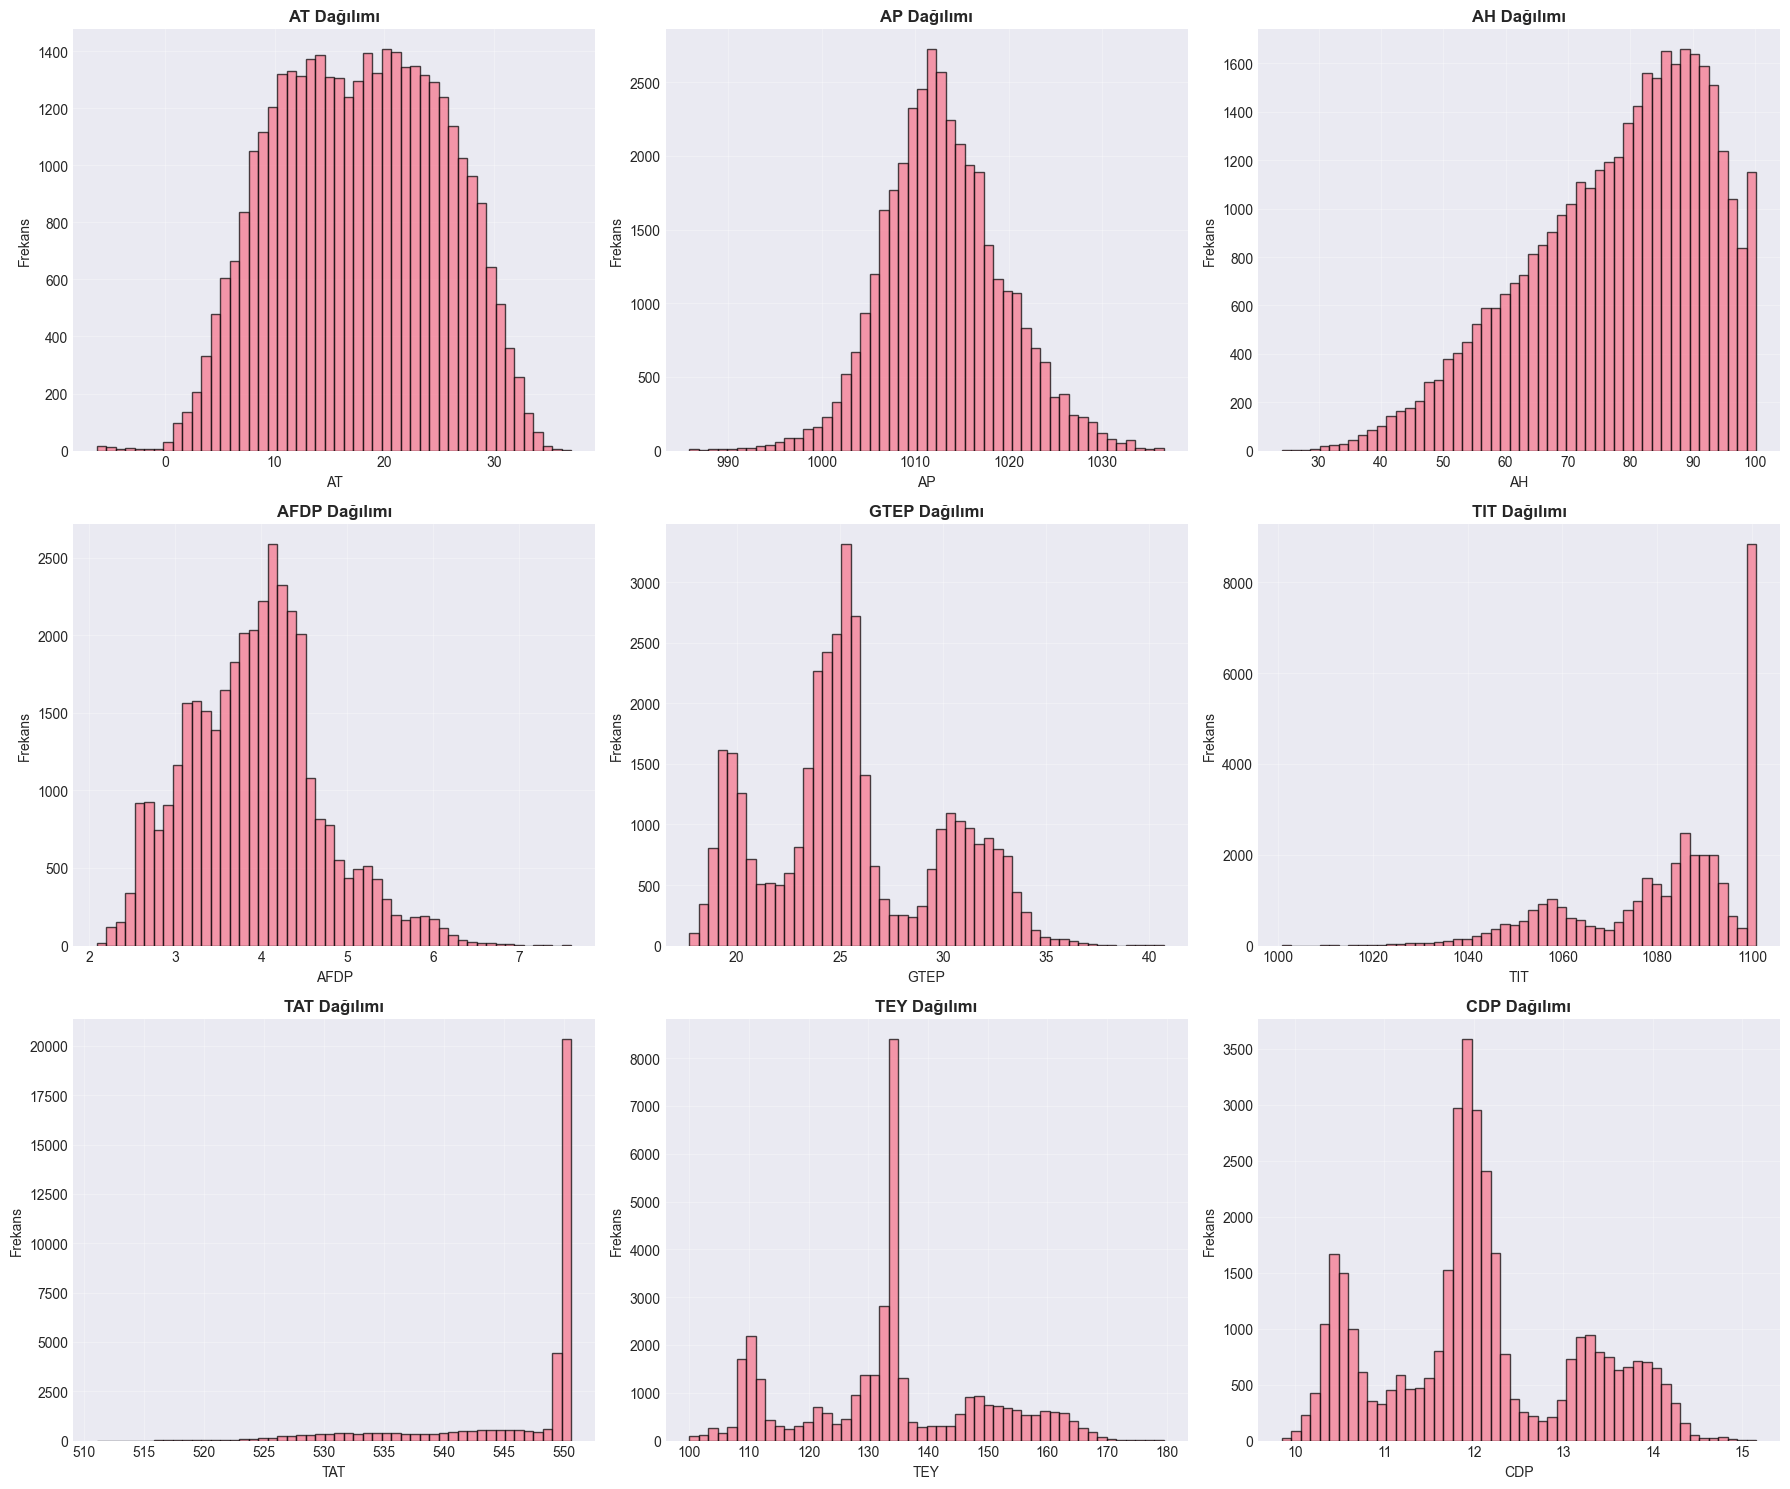

In [5]:
# Veri dağılımlarını görselleştir
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, col in enumerate(feature_columns):
    axes[idx].hist(X[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} Dağılımı', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frekans')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


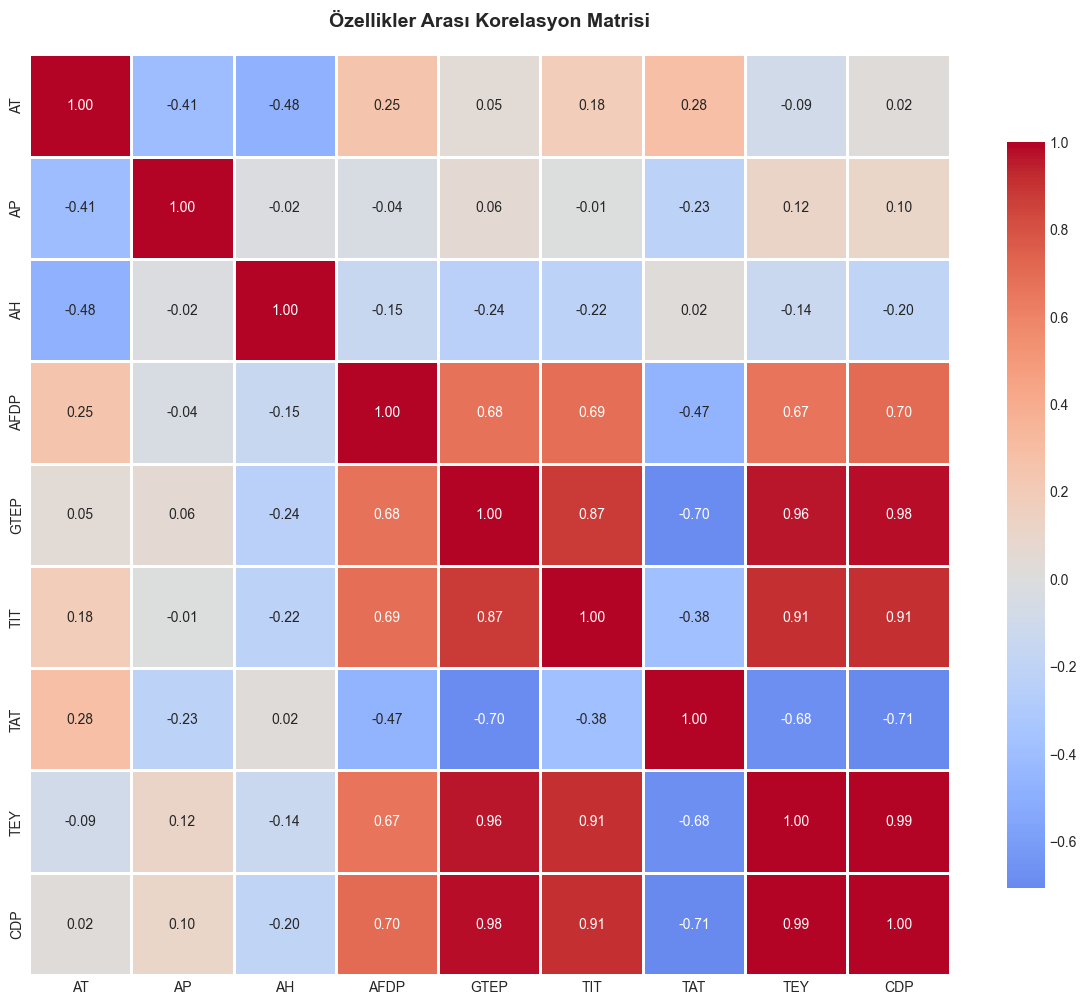

In [6]:
# Korelasyon matrisi
correlation_matrix = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Özellikler Arası Korelasyon Matrisi', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [7]:
# Veriyi normalize et (clustering için önemli!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

print("Veri normalize edildi!")
print(f"Normalize edilmiş veri özeti:")
print(X_scaled_df.describe())


Veri normalize edildi!
Normalize edilmiş veri özeti:
                 AT            AP            AH          AFDP          GTEP  \
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04   
mean  -1.114182e-16  5.273797e-15 -5.694710e-16  1.485577e-16  5.261417e-16   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -3.215577e+00 -4.211524e+00 -3.719067e+00 -2.375059e+00 -1.874640e+00   
25%   -7.964882e-01 -6.606830e-01 -6.693112e-01 -7.363991e-01 -5.802810e-01   
50%    1.185304e-02 -7.274427e-02  1.799983e-01  1.574091e-02 -1.095835e-01   
75%    7.992472e-01  6.080269e-01  7.958550e-01  5.832377e-01  8.334799e-01   
max    2.603647e+00  3.640553e+00  1.544343e+00  4.761549e+00  3.611191e+00   

                TIT           TAT           TEY           CDP  
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  
mean   9.619108e-15 -8.343988e-15  9.826470e-16 -4.596002e-16  
std    1.000014e+00  1.000014e+00  1.000014

## 3. Optimal Küme Sayısını Belirleme (Elbow Method & Silhouette Score)


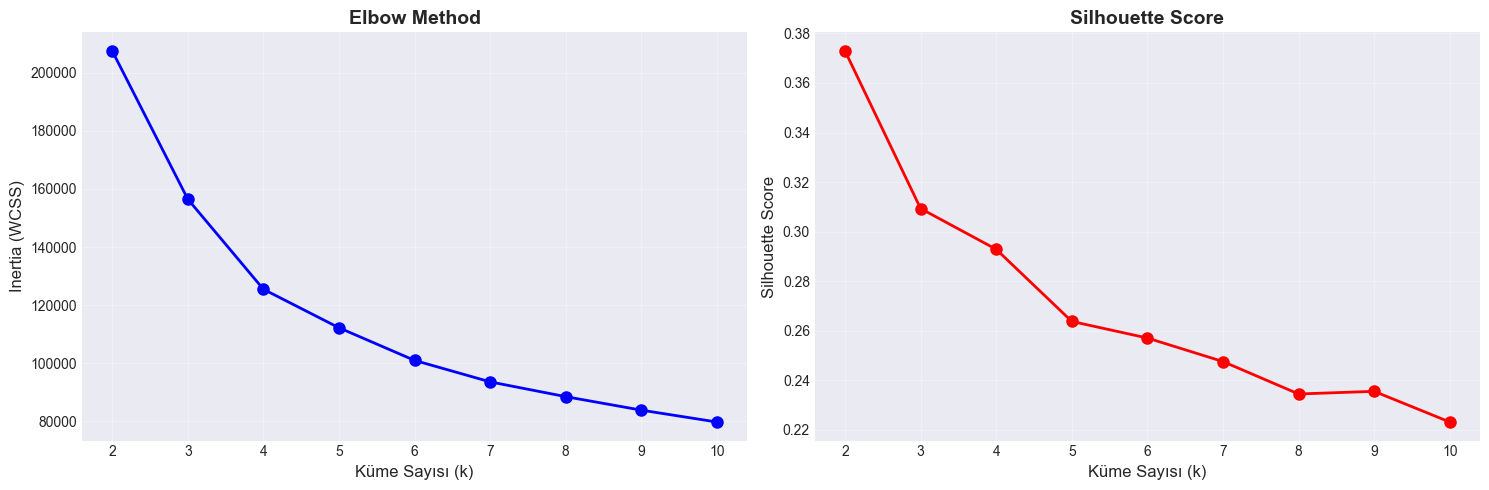


En yüksek Silhouette Score: 0.3730
Optimal küme sayısı (Silhouette'e göre): 2


In [8]:
# Elbow Method ve Silhouette Score ile optimal küme sayısını bul
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Küme Sayısı (k)', fontsize=12)
axes[0].set_ylabel('Inertia (WCSS)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Küme Sayısı (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# En iyi k değerini bul
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nEn yüksek Silhouette Score: {max(silhouette_scores):.4f}")
print(f"Optimal küme sayısı (Silhouette'e göre): {optimal_k}")


## 4. K-Means Clustering


In [9]:
# K-Means clustering uygula
n_clusters = optimal_k
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Sonuçları veri setine ekle
df['KMeans_Cluster'] = kmeans_labels

print(f"K-Means clustering tamamlandı!")
print(f"Küme sayısı: {n_clusters}")
print(f"\nKüme dağılımları:")
print(df['KMeans_Cluster'].value_counts().sort_index())


K-Means clustering tamamlandı!
Küme sayısı: 2

Küme dağılımları:
KMeans_Cluster
0     9625
1    27108
Name: count, dtype: int64


In [10]:
# Clustering metriklerini hesapla
silhouette_avg = silhouette_score(X_scaled, kmeans_labels)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans_labels)

print("Clustering Performans Metrikleri:")
print(f"Silhouette Score: {silhouette_avg:.4f} (Yüksek = Daha iyi, -1 ile 1 arası)")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (Düşük = Daha iyi)")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f} (Yüksek = Daha iyi)")


Clustering Performans Metrikleri:
Silhouette Score: 0.3730 (Yüksek = Daha iyi, -1 ile 1 arası)
Davies-Bouldin Index: 1.0868 (Düşük = Daha iyi)
Calinski-Harabasz Score: 21793.2717 (Yüksek = Daha iyi)


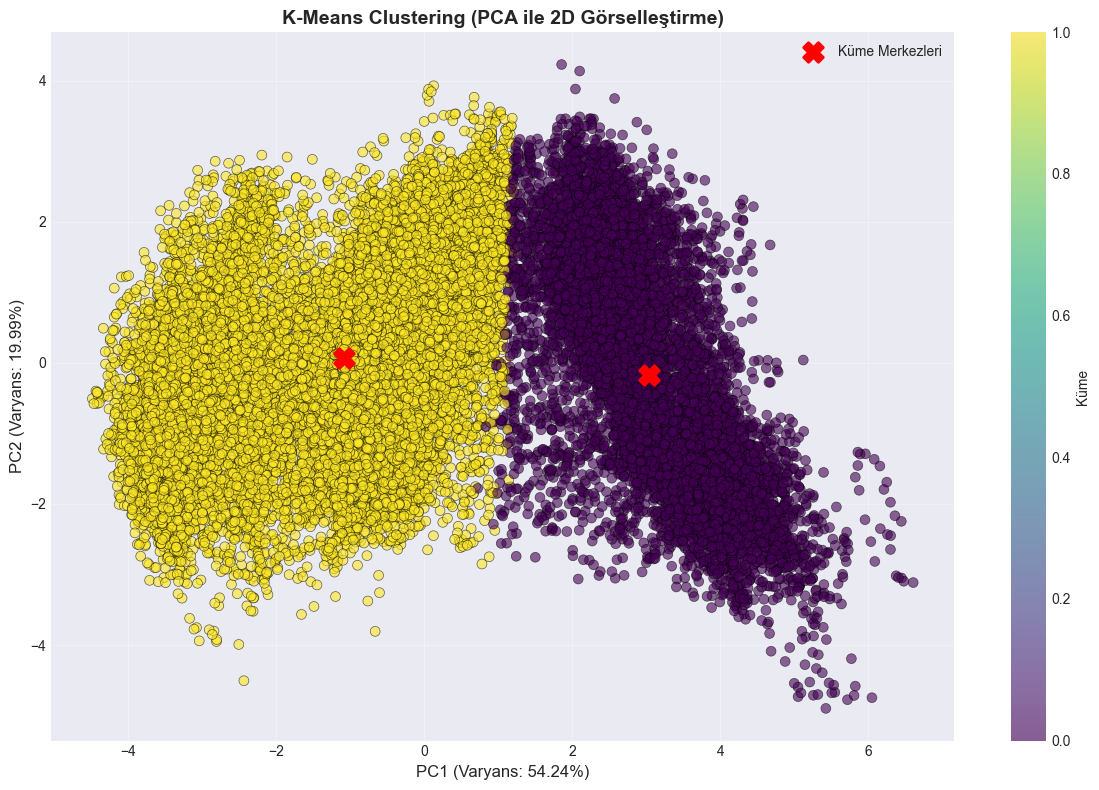

Toplam varyans açıklama oranı: 74.24%


In [ ]:
# PCA ile 2D görselleştirme
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# K-Means sonuçlarını görselleştir
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Küme')

# Küme merkezlerini PCA uzayına transform et
cluster_centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1],
            c='red', marker='X', s=200, label='Küme Merkezleri', linewidths=2)

plt.xlabel(f'PC1 (Varyans: {pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'PC2 (Varyans: {pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.title('K-Means Clustering (PCA ile 2D Görselleştirme)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Toplam varyans açıklama oranı: {pca.explained_variance_ratio_.sum():.2%}")


In [12]:
# Her kümenin özellik ortalamalarını analiz et
cluster_means = df.groupby('KMeans_Cluster')[feature_columns + target_columns].mean()
print("Küme Ortalamaları:")
print(cluster_means.round(2))


Küme Ortalamaları:
                   AT       AP     AH  AFDP   GTEP      TIT     TAT     TEY  \
KMeans_Cluster                                                                
0               17.97  1013.72  73.74  4.69  31.37  1099.49  537.02  154.05   
1               17.62  1012.84  79.33  3.66  23.50  1075.01  549.40  126.21   

                  CDP    CO    NOX  
KMeans_Cluster                      
0               13.56  1.29  62.25  
1               11.53  2.76  66.37  


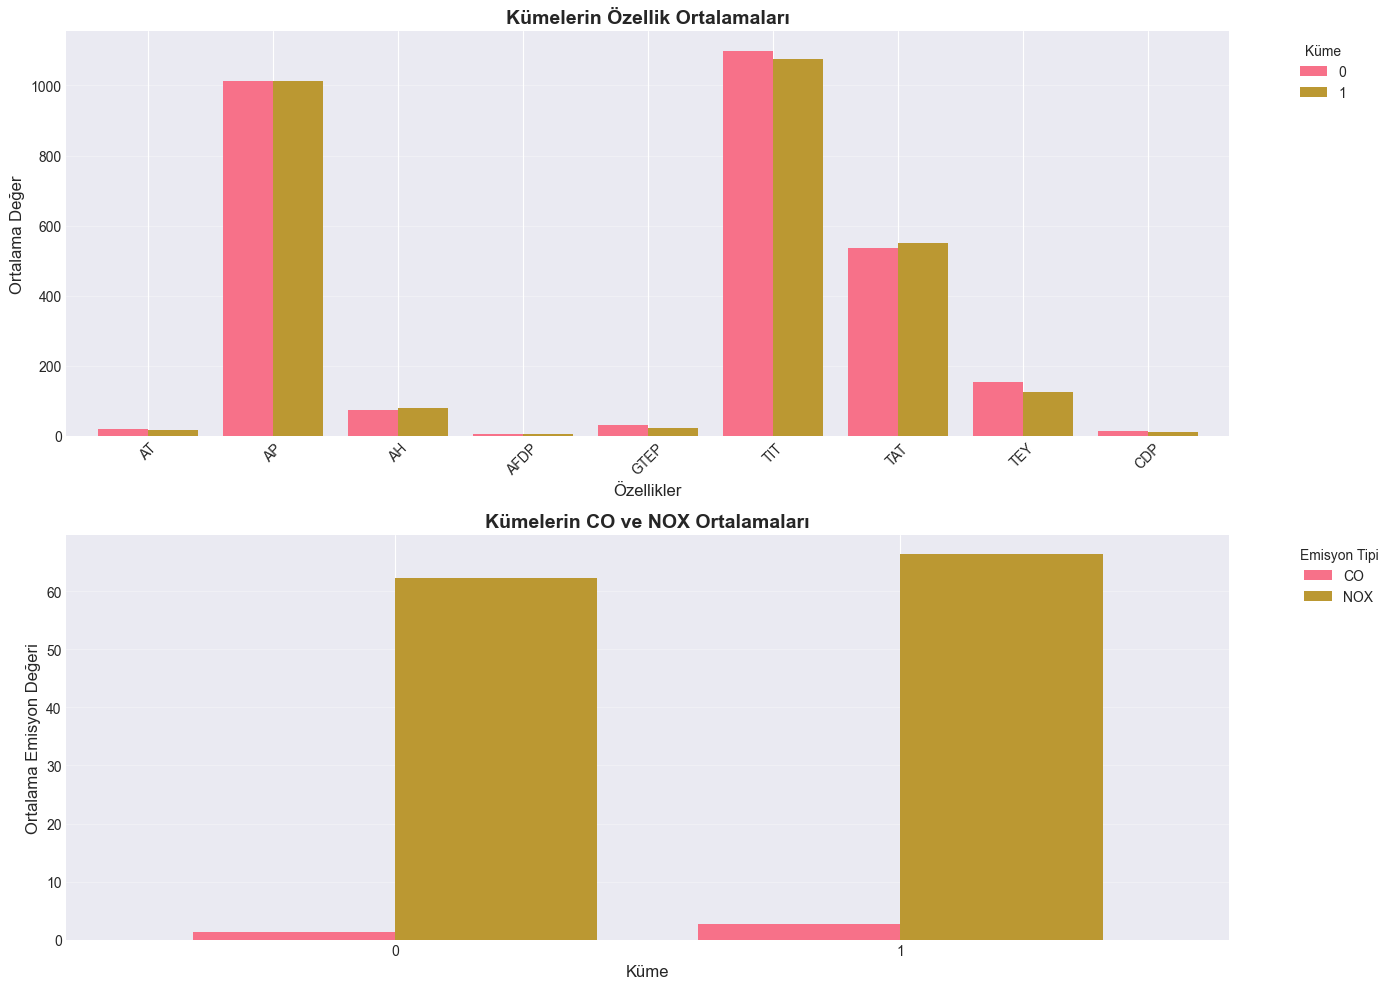

In [13]:
# Küme ortalamalarını görselleştir
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Özellikler için
cluster_means_features = cluster_means[feature_columns]
cluster_means_features.T.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Kümelerin Özellik Ortalamaları', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Özellikler', fontsize=12)
axes[0].set_ylabel('Ortalama Değer', fontsize=12)
axes[0].legend(title='Küme', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Hedef değişkenler için
cluster_means_targets = cluster_means[target_columns]
cluster_means_targets.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Kümelerin CO ve NOX Ortalamaları', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Küme', fontsize=12)
axes[1].set_ylabel('Ortalama Emisyon Değeri', fontsize=12)
axes[1].legend(title='Emisyon Tipi', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


## 5. DBSCAN Clustering


In [14]:
# DBSCAN parametrelerini optimize et
# Örnek veri kullanarak hızlı test (tüm veri çok büyük olabilir)
sample_size = min(10000, len(X_scaled))
X_sample = X_scaled[:sample_size]

# Farklı eps ve min_samples değerlerini dene
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples_values = [5, 10, 15, 20]

best_score = -1
best_params = None
best_labels = None

print("DBSCAN parametre optimizasyonu yapılıyor...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_sample)
        
        # Gürültü noktalarını hariç tut
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:  # En az 2 küme olmalı
            score = silhouette_score(X_sample[labels != -1], labels[labels != -1])
            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)
                best_labels = labels

if best_params:
    print(f"\nEn iyi parametreler: eps={best_params[0]}, min_samples={best_params[1]}")
    print(f"En iyi Silhouette Score: {best_score:.4f}")
    
    # Tüm veriye uygula
    dbscan_final = DBSCAN(eps=best_params[0], min_samples=best_params[1])
    dbscan_labels = dbscan_final.fit_predict(X_scaled)
    df['DBSCAN_Cluster'] = dbscan_labels
    
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise_dbscan = list(dbscan_labels).count(-1)
    
    print(f"\nDBSCAN Sonuçları:")
    print(f"Küme sayısı: {n_clusters_dbscan}")
    print(f"Gürültü noktası sayısı: {n_noise_dbscan} ({n_noise_dbscan/len(dbscan_labels)*100:.2f}%)")
    print(f"\nKüme dağılımları:")
    print(pd.Series(dbscan_labels).value_counts().sort_index())
else:
    print("Uygun parametreler bulunamadı. Varsayılan değerler kullanılıyor...")
    dbscan_final = DBSCAN(eps=2.0, min_samples=10)
    dbscan_labels = dbscan_final.fit_predict(X_scaled)
    df['DBSCAN_Cluster'] = dbscan_labels


DBSCAN parametre optimizasyonu yapılıyor...

En iyi parametreler: eps=1.0, min_samples=10
En iyi Silhouette Score: 0.3540

DBSCAN Sonuçları:
Küme sayısı: 3
Gürültü noktası sayısı: 350 (0.95%)

Küme dağılımları:
-1      350
 0    36337
 1        8
 2       38
Name: count, dtype: int64


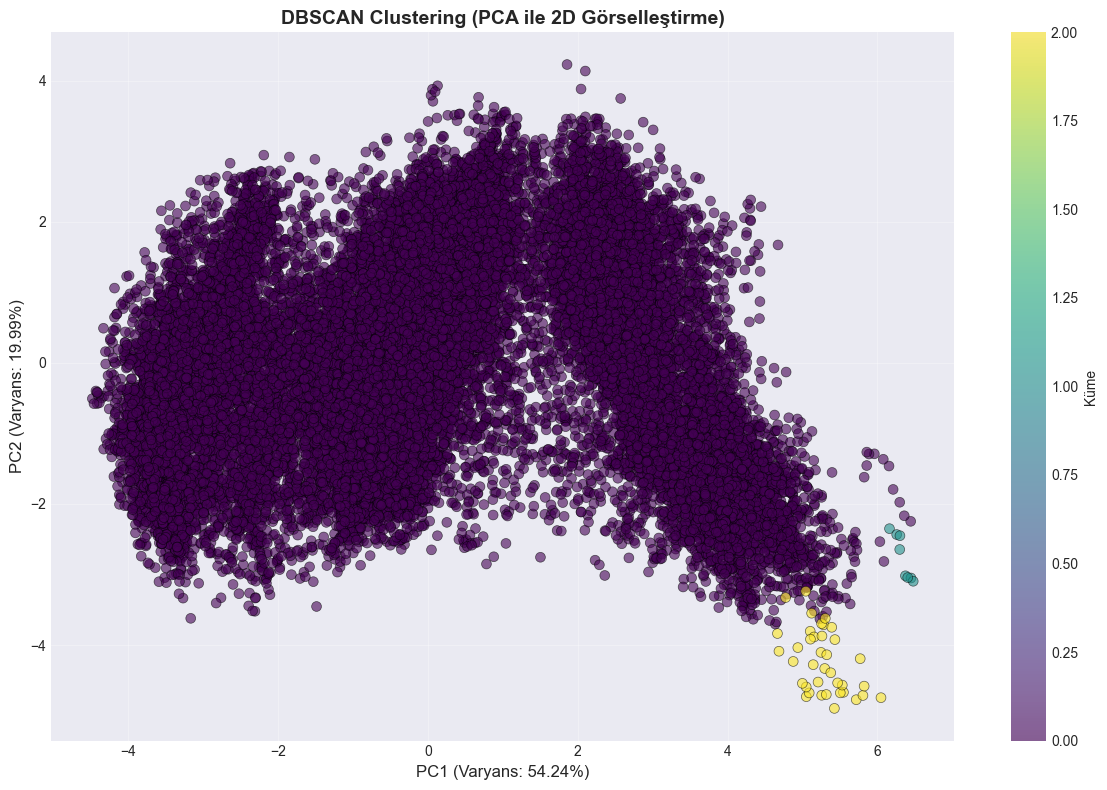

In [15]:
# DBSCAN sonuçlarını görselleştir (gürültü hariç)
if -1 in dbscan_labels:
    mask = dbscan_labels != -1
    X_pca_dbscan = X_pca[mask]
    dbscan_labels_clean = dbscan_labels[mask]
else:
    X_pca_dbscan = X_pca
    dbscan_labels_clean = dbscan_labels

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_dbscan[:, 0], X_pca_dbscan[:, 1], 
                     c=dbscan_labels_clean, cmap='viridis', 
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Küme')
plt.xlabel(f'PC1 (Varyans: {pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'PC2 (Varyans: {pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.title('DBSCAN Clustering (PCA ile 2D Görselleştirme)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Hierarchical (Agglomerative) Clustering


In [ ]:
# Hierarchical Clustering uygula
# Farklı linkage metodlarını dene
linkage_methods = ['ward', 'complete', 'average']
best_hier_score = -1
best_hier_method = None
best_hier_labels = None

print("Hierarchical Clustering optimizasyonu yapılıyor...")
for linkage in linkage_methods:
    try:
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        hier_labels = hierarchical.fit_predict(X_scaled)
        
        # En az 2 küme olmalı silhouette_score için
        n_unique_labels = len(set(hier_labels))
        if n_unique_labels > 1:
            score = silhouette_score(X_scaled, hier_labels)
            
            if score > best_hier_score:
                best_hier_score = score
                best_hier_method = linkage
                best_hier_labels = hier_labels
        else:
            print(f"  {linkage} linkage: Tek küme oluştu, atlanıyor...")
    except Exception as e:
        print(f"  {linkage} linkage: Hata - {str(e)}")
        continue

if best_hier_method is not None:
    print(f"\nEn iyi linkage metodu: {best_hier_method}")
    print(f"En iyi Silhouette Score: {best_hier_score:.4f}")
    
    df['Hierarchical_Cluster'] = best_hier_labels
    print(f"\nKüme dağılımları:")
    print(df['Hierarchical_Cluster'].value_counts().sort_index())
else:
    print("\nUygun sonuç bulunamadı. Varsayılan değerler kullanılıyor...")
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    best_hier_labels = hierarchical.fit_predict(X_scaled)
    df['Hierarchical_Cluster'] = best_hier_labels
    best_hier_method = 'ward'
    best_hier_score = silhouette_score(X_scaled, best_hier_labels)


Hierarchical Clustering optimizasyonu yapılıyor...
  ward linkage: Tek küme oluştu, atlanıyor...
  complete linkage: Tek küme oluştu, atlanıyor...


In [ ]:
# Hierarchical clustering sonuçlarını görselleştir
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_hier_labels, 
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Küme')
plt.xlabel(f'PC1 (Varyans: {pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'PC2 (Varyans: {pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.title(f'Hierarchical Clustering ({best_hier_method} linkage) - PCA ile 2D Görselleştirme', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Algoritma Karşılaştırması

In [ ]:
# Tüm algoritmaların performansını karşılaştır
algorithms = {
    'K-Means': kmeans_labels,
    'DBSCAN': dbscan_labels,
    'Hierarchical': best_hier_labels
}

comparison_results = []

for name, labels in algorithms.items():
    try:
        # Gürültü noktalarını kontrol et
        if -1 in labels:
            mask = labels != -1
            labels_clean = labels[mask]
            X_clean = X_scaled[mask]
        else:
            labels_clean = labels
            X_clean = X_scaled
        
        # En az 2 küme olmalı
        n_unique_labels = len(set(labels_clean))
        if n_unique_labels > 1:
            score = silhouette_score(X_clean, labels_clean)
            davies_b = davies_bouldin_score(X_clean, labels_clean)
            n_clusters_alg = n_unique_labels
        else:
            score = -1
            davies_b = float('inf')
            n_clusters_alg = n_unique_labels
            
    except Exception as e:
        print(f"{name} için hata: {str(e)}")
        score = -1
        davies_b = float('inf')
        n_clusters_alg = len(set(labels)) - (1 if -1 in labels else 0)
    
    comparison_results.append({
        'Algorithm': name,
        'Silhouette Score': score,
        'Davies-Bouldin Index': davies_b,
        'Number of Clusters': n_clusters_alg
    })

comparison_df = pd.DataFrame(comparison_results)
print("Algoritma Karşılaştırması:")
print(comparison_df.to_string(index=False))


In [ ]:
# Karşılaştırma görselleştirmesi
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Silhouette Score karşılaştırması
axes[0].bar(comparison_df['Algorithm'], comparison_df['Silhouette Score'], 
           color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Score Karşılaştırması', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Davies-Bouldin Index karşılaştırması (düşük = daha iyi)
axes[1].bar(comparison_df['Algorithm'], comparison_df['Davies-Bouldin Index'], 
           color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1].set_title('Davies-Bouldin Index Karşılaştırması (Düşük = Daha İyi)', 
                 fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 8. Sonuçlar ve Öneriler


In [ ]:
# En iyi algoritmayı belirle
best_algorithm = comparison_df.loc[comparison_df['Silhouette Score'].idxmax(), 'Algorithm']
print(f"En iyi performans gösteren algoritma: {best_algorithm}")
print(f"\nDetaylı Analiz:")
print("="*60)

# K-Means için detaylı analiz
print("\nK-Means Clustering Analizi:")
print(f"- Küme sayısı: {n_clusters}")
print(f"- Silhouette Score: {silhouette_avg:.4f}")
print(f"- Her kümenin özellikleri:")
for cluster_id in range(n_clusters):
    cluster_data = df[df['KMeans_Cluster'] == cluster_id]
    print(f"\n  Küme {cluster_id} ({len(cluster_data)} örnek):")
    print(f"    - Ortalama CO: {cluster_data['CO'].mean():.4f}")
    print(f"    - Ortalama NOX: {cluster_data['NOX'].mean():.4f}")
    print(f"    - Ortalama TEY: {cluster_data['TEY'].mean():.2f}")

print("\n" + "="*60)
print("\nClustering analizi tamamlandı!")


In [ ]:
# Sonuçları CSV olarak kaydet
output_file = 'clustering_results.csv'
df.to_csv(output_file, index=False)
print(f"Sonuçlar '{output_file}' dosyasına kaydedildi!")
